In [123]:
import os
import csv
from glob import glob
from collections import Counter
from PIL import Image, ImageDraw, ImageFont
import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Function definitions

In [147]:
def extract_annotation(txt_path):
    csv_reader = csv.reader(open(txt_path, 'rt'), delimiter=' ')
    brands = []
    boxes = []
    for row in csv_reader:
        x1, y1, x2, y2, brand = row
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        brands.append(brand)
        boxes.append([x1, y1, x2, y2])
    return brands, boxes

def box_with_text(image, box, text=None, rectangle_bgr=(255,255,255)):
    # draw the bounding box
    cv2.rectangle(image, box[:2], box[2:], (0,255,0),int(np.ceil(image.shape[0] / 200)))
    if text is not None:
        font_scale = image.shape[0] / 200
        font_thickness = int(image.shape[0] / 200)
        font = cv2.FONT_HERSHEY_PLAIN
        # get the width and height of the text box
        (text_width, text_height) = cv2.getTextSize(text, font, fontScale=font_scale, thickness=1)[0]
        # set the text start position
        text_offset_x = box[0]
        text_offset_y = box[1] + text_height
        # make the coords of the box with a small padding of two pixels
        box_coords = ((text_offset_x, text_offset_y), (text_offset_x + text_width - 2, text_offset_y - text_height - 2))
        cv2.rectangle(image, box_coords[0], box_coords[1], rectangle_bgr, cv2.FILLED)
        cv2.putText(image, text, (text_offset_x, text_offset_y), font, fontScale=font_scale, color=(0, 0, 0), thickness=font_thickness)
    return image

def make_logo_image(image_path, annotation_path, show_brand=True):
    image = cv2.imread(image_path)
    brands, boxes = extract_annotation(annotation_path)
    for brand, box in zip(brands, boxes):
        box = tuple([int(x) for x in box])
        if show_brand:
            image = box_with_text(image, box, brand)    
        else:
            image = box_with_text(image, box)    
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def box_area(box):
    return (box[2] - box[0]) * (box[3] - box[1])

def box_aspect_ratio(box):
    # returns width/height
    return (box[2] - box[0]) / (box[3] - box[1])

def dataset_summary(path_annotations):
    # go through all the annotations
    files = os.listdir(path_annotations)
    all_brands = []
    areas = []
    rel_areas = []
    aspect_ratios = []
    for file in files:
        file_path = os.path.join(path_annotations, file)
        brands, boxes = extract_annotation(file_path)
        for brand, box in zip(brands, boxes):
            areas.append(box_area(box))
            aspect_ratios.append(box_aspect_ratio(box))
            all_brands.append(brand)
    # calculate how many we have
    brand_counter = Counter(all_brands)
    return brand_counter, areas, aspect_ratios

In [3]:
PATH_DATASET = "/home/mircea/HKT/Data/logo-dataset"
PATH_IMAGES = os.path.join(PATH_DATASET, "images")
PATH_ANNOTATIONS = os.path.join(PATH_DATASET, "annotations")

In [4]:
all_image_paths = sorted(glob(os.path.join(PATH_IMAGES, "*.*")))
all_annotation_paths = sorted(glob(os.path.join(PATH_ANNOTATIONS, "*.*")))

### Explore the dataset
See some random images and their annotations, number of instances per brand etc.

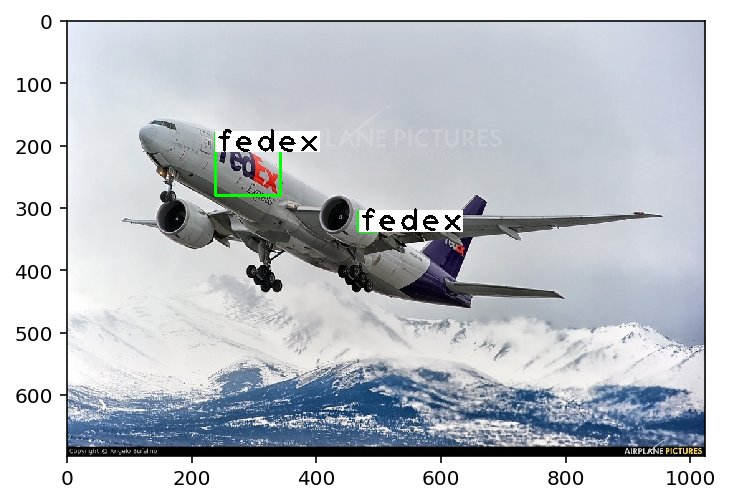

In [117]:
# show a random image and its annotations
idx = np.random.randint(len(all_image_paths))
image = make_logo_image(all_image_paths[idx], all_annotation_paths[idx], show_brand=True) 
plt.imshow(image)

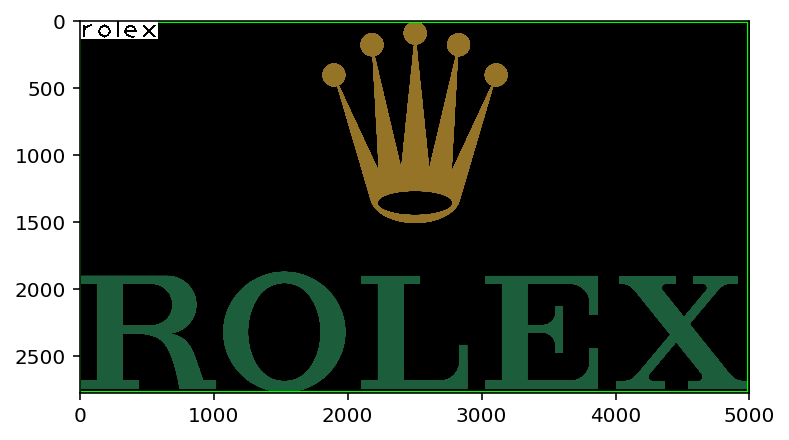

In [138]:
# show a specific image
name = "img_000006214"
image_path = os.path.join(PATH_IMAGES, name + ".jpg")
annotation_path = os.path.join(PATH_ANNOTATIONS, name + ".txt")
image = make_logo_image(image_path, annotation_path, show_brand=True) 
plt.imshow(image)

In [139]:
# get a summary of the dataset
brand_counter, areas, aspect_ratios = dataset_summary(PATH_ANNOTATIONS)

/home/mircea/HKT/Data/logo-dataset/annotations/img_000006214.txt


[('heineken_text', 1902), ('heineken', 1689), ('cocacola', 1426), ('nivea', 1351), ('fedex', 1316), ('bmw', 1089), ('pepsi', 1039), ('redbull', 961), ('mcdonalds', 920), ('starbucks', 899), ('kia', 872), ('dhl', 842), ('colgate', 824), ('nike', 794), ('kraft', 794), ('aldi', 782), ('gillette', 764), ('milka', 744), ('corona', 722), ('ferrari', 718)]


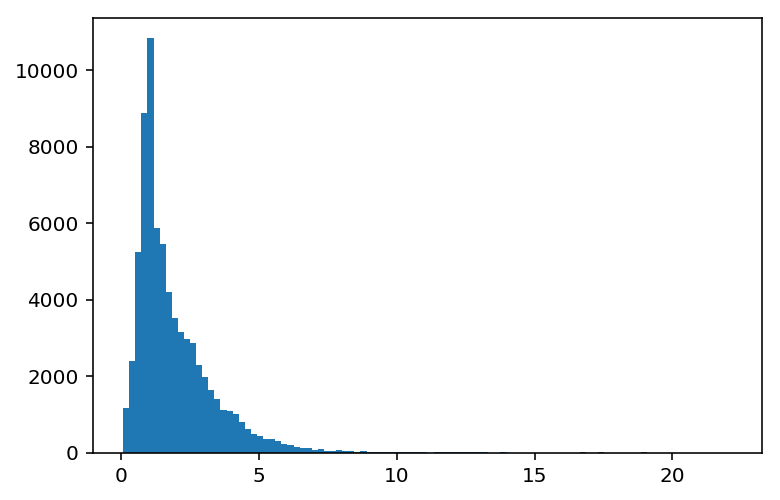

In [146]:
# most common brands
print(brand_counter.most_common(20))

# detection areas
plt.hist(aspect_ratios, 100);